[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shhommychon/mnist_generative_practice/blob/master/Diffusion.ipynb)

# MNIST Diffusion model 학습

## 환경설정

- PyTorch 버젼 다운그레이드 코드로 인해 세션이 자동으로 한번 꺼질 예정입니다. 다시 실행하면 됩니다.

In [1]:
# 현 CUDA 버젼 확인
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [2]:
# 파이썬 버젼 고정
import torch

# 현 PyTorch 버젼 확인
if torch.__version__.split('+')[0] != "1.11.0":
    print(f"Current PyTorch version is {torch.__version__}, downgrading to 1.11.0")

    # PyTorch 제거
    !pip uninstall torch torchvision -y

    # PyTorch 1.11.0 설치
    !pip install torch==1.11.0 torchvision==0.12.0 -f https://download.pytorch.org/whl/cu111/torch_stable.html

    # 런타임 강제 재시작
    import os
    os.kill(os.getpid(), 9)
else:
    print("PyTorch version is already 1.11.0")

PyTorch version is already 1.11.0


In [3]:
!git clone https://github.com/shhommychon/mnist_generative_practice.git

import sys
sys.path = ["./mnist_generative_practice"] + sys.path

Cloning into 'mnist_generative_practice'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 16 (delta 4), reused 15 (delta 3), pack-reused 0
Receiving objects: 100% (16/16), 7.91 KiB | 7.91 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [4]:
!apt install megatools

# mnist_feature_extractor.dth
!megadl 'https://mega.nz/file/DgUQyDyB#7Gyq_9kzCz8FcGZV659VD1Cq1_36wimGVOG2Eram3P8'

# mnist_classifier.dth
!megadl 'https://mega.nz/file/H49S3bTI#qsonzlkV3JMniTbyzV77BB9VLhwmh1OJLTgxuD4PEMM'

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  megatools
0 upgraded, 1 newly installed, 0 to remove and 31 not upgraded.
Need to get 207 kB of archives.
After this operation, 898 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 megatools amd64 1.10.3-1build1 [207 kB]
Fetched 207 kB in 2s (124 kB/s)
Selecting previously unselected package megatools.
(Reading database ... 121671 files and directories currently installed.)
Preparing to unpack .../megatools_1.10.3-1build1_amd64.deb ...
Unpacking megatools (1.10.3-1build1) ...
Setting up megatools (1.10.3-1build1) ...
Processing triggers for man-db (2.10.2-1) ...
Downloaded mnist_feature_extractor.dth
Downloaded mnist_classifier.dth


## 실습 코드

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np

### MNIST 데이터셋 다운로드 및 불러오기

- 다운로드 코드 원본: [devnson/mnist_pytorch](https://github.com/devnson/mnist_pytorch?tab=readme-ov-file#downloading-datasets)
- 불러오기 코드 원본: [devnson/mnist_pytorch](https://github.com/devnson/mnist_pytorch?tab=readme-ov-file#splitting-datasets)

In [6]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True,
                      transform=transforms.Compose([transforms.ToTensor()]))
mnist_testset = datasets.MNIST(root='./data', train=False, download=True,
                      transform=transforms.Compose([transforms.ToTensor()]))

mnist_valset, mnist_testset = torch.utils.data.random_split(
                                mnist_testset,
                                [
                                    int(0.9 * len(mnist_testset)),
                                    int(0.1 * len(mnist_testset))
                                ]
                            )
train_dataloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_valset, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(mnist_testset, batch_size=32, shuffle=False)

print("Training dataset size: ", len(mnist_trainset))
print("Validation dataset size: ", len(mnist_valset))
print("Testing dataset size: ", len(mnist_testset))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Training dataset size:  60000
Validation dataset size:  9000
Testing dataset size:  1000


### 모델 및 손실함수/옵티마이저 등 설정

In [7]:
# Diffusion model 학습 보조용 사전학습 MNIST 분류기
from models.classifier import MNISTClassifier

c_model = MNISTClassifier()
c_model.feature_extractor.load_state_dict(torch.load("mnist_feature_extractor.dth"))
c_model.classifier.load_state_dict(torch.load("mnist_classifier.dth"))

if (torch.cuda.is_available()): c_model.cuda()

# freeze
for param in c_model.parameters(): param.requires_grad = False

c_model

MNISTClassifier(
  (feature_extractor): ConvFeatExtractor(
    (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (linear): Linear(in_features=3136, out_features=128, bias=True)
    (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (relu): ReLU()
  )
  (classifier): ClassifierHead(
    (dropout): SoftDropout(
      (dropouts): ModuleList(
        (0): Dropout(p=0.5, inplace=False)
        (1): Dropout(p=0.5, inplace=False)
        (2): Dropout(p=0.5, inplace=False)
        (3): Dropout(p=0.5, inplace=False)
        (4): Dropout(p=0.5, inplace=False)
      )
    )
    (relu): ReLU()
    (linear): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [8]:
from models.diffusion import MNISTDiffusion

model = MNISTDiffusion()

if (torch.cuda.is_available()): model.cuda()

model

MNISTDiffusion(
  (label_emb): Embedding(10, 32)
  (linear): Linear(in_features=816, out_features=784, bias=True)
  (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
)

In [9]:
pixelwise_loss = nn.L1Loss()
classification_loss = nn.CrossEntropyLoss()

lr=0.0002
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

decay_rate = 0.99
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=decay_rate)

max_epochs = 100
best_val_loss = 100
max_patience = 5

### 이미지 생성 코드

- 학습 중간 확인 용도

In [10]:
def generate_images(model, noise, class_label):
    model.eval()
    with torch.no_grad():
        for _ in range(model.num_steps):
            noise = model(noise, class_label)
        recon_image = noise.clone()

    return recon_image

### 모델 학습 코드


Epoch: 1/100,
	Train Loss: 1.38750968
		classification loss: 1.18131015
		pixelwise loss: 1.35797692
	Val Loss: 1.33151240
		classification loss: 0.00432463
		pixelwise loss: 1.33140428


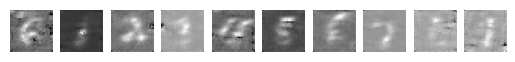

	Saving the model state dictionary for Epoch: 1 with Validation loss: 1.33151240

Epoch: 2/100,
	Train Loss: 1.01938999
		classification loss: 0.52459393
		pixelwise loss: 1.00627514
	Val Loss: 1.17968058
		classification loss: 0.56654004
		pixelwise loss: 1.16551708


<Figure size 640x480 with 0 Axes>

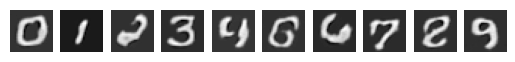

	Saving the model state dictionary for Epoch: 2 with Validation loss: 1.17968058

Epoch: 3/100,
	Train Loss: 0.83259399
		classification loss: 0.57547797
		pixelwise loss: 0.81820704
	Val Loss: 1.19469148
		classification loss: 1.06796192
		pixelwise loss: 1.16799243


<Figure size 640x480 with 0 Axes>

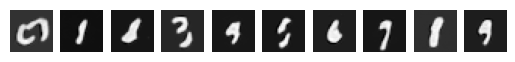

	Loss not decreased. Will wait for 4 more epochs...

Epoch: 4/100,
	Train Loss: 0.81789339
		classification loss: 0.59252835
		pixelwise loss: 0.80308019
	Val Loss: 1.16698223
		classification loss: 0.72752014
		pixelwise loss: 1.14879423


<Figure size 640x480 with 0 Axes>

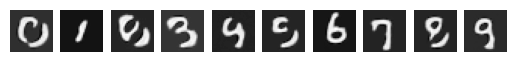

	Saving the model state dictionary for Epoch: 4 with Validation loss: 1.16698223

Epoch: 5/100,
	Train Loss: 0.81094604
		classification loss: 0.59077086
		pixelwise loss: 0.79617677
	Val Loss: 1.16586190
		classification loss: 0.72906419
		pixelwise loss: 1.14763530


<Figure size 640x480 with 0 Axes>

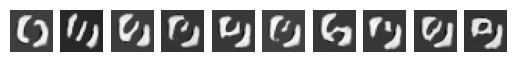

	Saving the model state dictionary for Epoch: 5 with Validation loss: 1.16586190

Epoch: 6/100,
	Train Loss: 0.80745222
		classification loss: 0.58858894
		pixelwise loss: 0.79273750
	Val Loss: 1.15950467
		classification loss: 0.76757807
		pixelwise loss: 1.14031522


<Figure size 640x480 with 0 Axes>

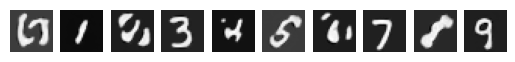

	Saving the model state dictionary for Epoch: 6 with Validation loss: 1.15950467

Epoch: 7/100,
	Train Loss: 0.80492983
		classification loss: 0.58270096
		pixelwise loss: 0.79036231
	Val Loss: 1.14687873
		classification loss: 0.63520581
		pixelwise loss: 1.13099859


<Figure size 640x480 with 0 Axes>

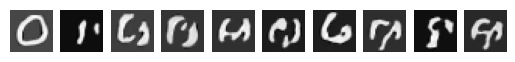

	Saving the model state dictionary for Epoch: 7 with Validation loss: 1.14687873

Epoch: 8/100,
	Train Loss: 0.80158350
		classification loss: 0.57606907
		pixelwise loss: 0.78718177
	Val Loss: 1.14431375
		classification loss: 0.73284898
		pixelwise loss: 1.12599253


<Figure size 640x480 with 0 Axes>

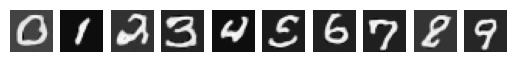

	Saving the model state dictionary for Epoch: 8 with Validation loss: 1.14431375

Epoch: 9/100,
	Train Loss: 0.80050568
		classification loss: 0.56605813
		pixelwise loss: 0.78635423
	Val Loss: 1.13938849
		classification loss: 0.61368555
		pixelwise loss: 1.12404635


<Figure size 640x480 with 0 Axes>

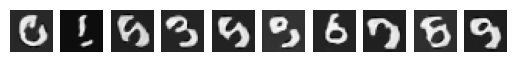

	Saving the model state dictionary for Epoch: 9 with Validation loss: 1.13938849

Epoch: 10/100,
	Train Loss: 0.79999425
		classification loss: 0.56264777
		pixelwise loss: 0.78592805
	Val Loss: 1.16023164
		classification loss: 0.76291521
		pixelwise loss: 1.14115876


<Figure size 640x480 with 0 Axes>

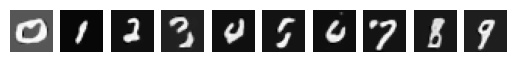

	Loss not decreased. Will wait for 4 more epochs...

Epoch: 11/100,
	Train Loss: 0.79741737
		classification loss: 0.55903966
		pixelwise loss: 0.78344138
	Val Loss: 1.15815514
		classification loss: 0.64718564
		pixelwise loss: 1.14197550


<Figure size 640x480 with 0 Axes>

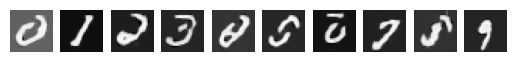

	Loss not decreased. Will wait for 3 more epochs...

Epoch: 12/100,
	Train Loss: 0.79747783
		classification loss: 0.55201176
		pixelwise loss: 0.78367753
	Val Loss: 1.13758195
		classification loss: 0.64646509
		pixelwise loss: 1.12142032


<Figure size 640x480 with 0 Axes>

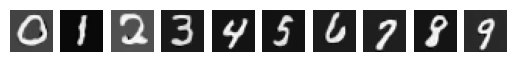

	Saving the model state dictionary for Epoch: 12 with Validation loss: 1.13758195

Epoch: 13/100,
	Train Loss: 0.79448457
		classification loss: 0.54987255
		pixelwise loss: 0.78073776
	Val Loss: 1.13299860
		classification loss: 0.46689978
		pixelwise loss: 1.12132611


<Figure size 640x480 with 0 Axes>

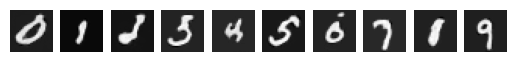

	Saving the model state dictionary for Epoch: 13 with Validation loss: 1.13299860

Epoch: 14/100,
	Train Loss: 0.79461081
		classification loss: 0.54362125
		pixelwise loss: 0.78102027
	Val Loss: 1.12693993
		classification loss: 0.49339729
		pixelwise loss: 1.11460500


<Figure size 640x480 with 0 Axes>

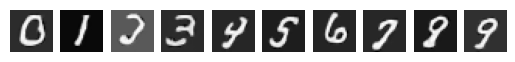

	Saving the model state dictionary for Epoch: 14 with Validation loss: 1.12693993

Epoch: 15/100,
	Train Loss: 0.79233303
		classification loss: 0.54303666
		pixelwise loss: 0.77875712
	Val Loss: 1.13256465
		classification loss: 0.39155309
		pixelwise loss: 1.12277583


<Figure size 640x480 with 0 Axes>

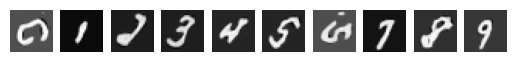

	Loss not decreased. Will wait for 4 more epochs...

Epoch: 16/100,
	Train Loss: 0.79391845
		classification loss: 0.54251804
		pixelwise loss: 0.78035550
	Val Loss: 1.12909248
		classification loss: 0.43082610
		pixelwise loss: 1.11832183


<Figure size 640x480 with 0 Axes>

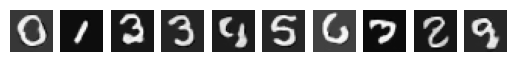

	Loss not decreased. Will wait for 3 more epochs...

Epoch: 17/100,
	Train Loss: 0.79071501
		classification loss: 0.53696926
		pixelwise loss: 0.77729077
	Val Loss: 1.11677446
		classification loss: 0.39579588
		pixelwise loss: 1.10687956


<Figure size 640x480 with 0 Axes>

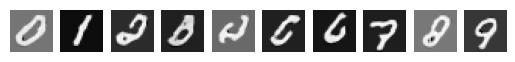

	Saving the model state dictionary for Epoch: 17 with Validation loss: 1.11677446

Epoch: 18/100,
	Train Loss: 0.79038293
		classification loss: 0.53099378
		pixelwise loss: 0.77710809
	Val Loss: 1.10541497
		classification loss: 0.27551135
		pixelwise loss: 1.09852719


<Figure size 640x480 with 0 Axes>

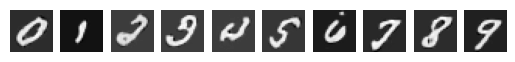

	Saving the model state dictionary for Epoch: 18 with Validation loss: 1.10541497

Epoch: 19/100,
	Train Loss: 0.78863069
		classification loss: 0.52870635
		pixelwise loss: 0.77541304
	Val Loss: 1.12694012
		classification loss: 0.49198398
		pixelwise loss: 1.11464052


<Figure size 640x480 with 0 Axes>

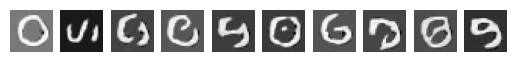

	Loss not decreased. Will wait for 4 more epochs...

Epoch: 20/100,
	Train Loss: 0.78779627
		classification loss: 0.52489366
		pixelwise loss: 0.77467393
	Val Loss: 1.10934464
		classification loss: 0.30042020
		pixelwise loss: 1.10183413


<Figure size 640x480 with 0 Axes>

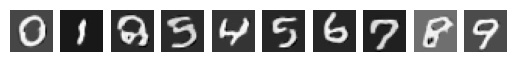

	Loss not decreased. Will wait for 3 more epochs...

Epoch: 21/100,
	Train Loss: 0.78683005
		classification loss: 0.52700979
		pixelwise loss: 0.77365481
	Val Loss: 1.14584921
		classification loss: 0.44822794
		pixelwise loss: 1.13464351


<Figure size 640x480 with 0 Axes>

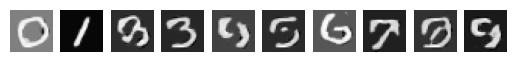

	Loss not decreased. Will wait for 2 more epochs...

Epoch: 22/100,
	Train Loss: 0.78612810
		classification loss: 0.51940835
		pixelwise loss: 0.77314289
	Val Loss: 1.11692316
		classification loss: 0.35818552
		pixelwise loss: 1.10796852


<Figure size 640x480 with 0 Axes>

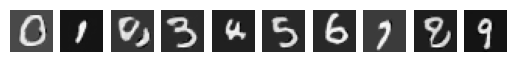

	Loss not decreased. Will wait for 1 more epochs...

Epoch: 23/100,
	Train Loss: 0.78687453
		classification loss: 0.51684380
		pixelwise loss: 0.77395343
	Val Loss: 1.11306330
		classification loss: 0.33091048
		pixelwise loss: 1.10479054


<Figure size 640x480 with 0 Axes>

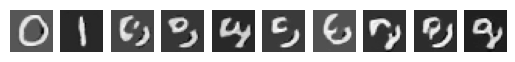

	Loss not decreased. Will wait for 0 more epochs...


<Figure size 640x480 with 0 Axes>

In [11]:
device = "cuda" if (torch.cuda.is_available()) else "cpu"
patience = max_patience
for epoch in range(max_epochs):
    total_train_loss = {
        "loss_class": 0,
        "loss_pixel": 0,
        "loss_total": 0,
    }
    total_val_loss = {
        "loss_class": 0,
        "loss_pixel": 0,
        "loss_total": 0,
    }

    model.train()

    # training
    for iter, (image, label) in enumerate(train_dataloader):
        image = image.to(device)
        label = label.to(device)

        # Forward diffusion process
        noisy_images = [image.clone()]
        noisy_image = image.clone()
        for _ in range(model.num_steps):
            noisy_image = model(noisy_image, backward=False)
            noisy_images.append(noisy_image.clone())

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Backward diffusion process
        recon_image = noisy_images.pop()
        train_pixel_loss = torch.tensor(0.).to(device)
        train_class_loss = torch.tensor(0.).to(device)
        for _ in range(model.num_steps):
            recon_image = model(recon_image, label)
            train_pixel_loss += pixelwise_loss(recon_image, image) # noisy_images[-1])
            class_pred = c_model(recon_image)
            train_class_loss += classification_loss(class_pred, label)
            recon_image = noisy_images.pop()

        # loss computation and backpropagation
        this_train_loss = train_pixel_loss + 0.025 * train_class_loss
        this_train_loss.backward()

        # Update diffusion model parameters
        optimizer.step()

        total_train_loss["loss_class"] += train_class_loss.item()
        total_train_loss["loss_pixel"] += train_pixel_loss.item()
        total_train_loss["loss_total"] += this_train_loss.item()

    # Step the learning rate schedulers
    scheduler.step()

    total_train_loss = { k: train_loss / (iter + 1) for k, train_loss
                                                in total_train_loss.items() }

    # validation
    model.eval()

    for iter, (image, label) in enumerate(val_dataloader):
        image = image.to(device)
        label = label.to(device)

        # Forward diffusion process
        noisy_images = [image.clone()]
        noisy_image = image.clone()
        for _ in range(model.num_steps):
            noisy_image = model(noisy_image, backward=False)
            noisy_images.append(noisy_image.clone())

        # Backward diffusion process
        recon_image = noisy_images.pop()
        val_pixel_loss = torch.tensor(0.).to(device)
        val_class_loss = torch.tensor(0.).to(device)
        for _ in range(model.num_steps):
            recon_image = model(recon_image, label)
            val_pixel_loss += pixelwise_loss(recon_image, image) # noisy_images[-1])
            class_pred = c_model(recon_image)
            val_class_loss += classification_loss(class_pred, label)
            _ = noisy_images.pop()

        total_val_loss["loss_class"] += val_class_loss.item()
        total_val_loss["loss_pixel"] += val_pixel_loss.item()
        total_val_loss["loss_total"] += (val_pixel_loss + 0.025 * val_class_loss).item()

    total_val_loss = { k: val_loss / (iter + 1) for k, val_loss
                                                in total_val_loss.items() }

    print(f"\nEpoch: {epoch+1}/{max_epochs},"
          f"\n\tTrain Loss: {total_train_loss['loss_total']:.8f}"
          f"\n\t\tclassification loss: {total_train_loss['loss_class']:.8f}"
          f"\n\t\tpixelwise loss: {total_train_loss['loss_pixel']:.8f}"
          f"\n\tVal Loss: {total_val_loss['loss_total']:.8f}"
          f"\n\t\tclassification loss: {total_val_loss['loss_class']:.8f}"
          f"\n\t\tpixelwise loss: {total_val_loss['loss_pixel']:.8f}")

    noise = torch.randn(1, 1, 28, 28).repeat(10, 1, 1, 1).to(device)
    class_label = torch.tensor([ n for n in range(10) ]).to(device)
    result = generate_images(model, noise, class_label).cpu().detach().numpy()

    fig, ax = plt.subplots(nrows=1, ncols=10)
    for i, image in enumerate(result):
        plt.subplot(1, 10, i+1)
        plt.imshow(image.reshape(28, 28), cmap="gray")
        plt.axis("off")
    plt.show()
    plt.clf()

    if total_val_loss["loss_total"] < best_val_loss:
        best_val_loss = total_val_loss["loss_total"]
        print(f"\tSaving the model state dictionary for Epoch: {epoch+1} with Validation loss: {best_val_loss:.8f}")
        torch.save(model.state_dict(), "mnist_diffusion.dth")
        patience = max_patience
    else:
        patience -= 1
        print(f"\tLoss not decreased. Will wait for {patience} more epochs...")

    if patience <= 0: break


### 사전학습 모델 불러오기

- 위 모델 학습 코드를 실행하기 귀찮을 경우에만 이 셀을 실행

In [11]:
!apt install megatools

# mnist_diffusion.dth
!megadl 'https://mega.nz/file/Sg90lRhQ#LBZAwdB26Il-cqFYs7Q-WpX7AOWwRl2a1OlQ2vXK9J4'

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
megatools is already the newest version (1.10.3-1build1).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.
Downloaded mnist_diffusion.dth


### 학습 모델 테스트

#### 일반 이미지 생성

In [12]:
device = "cuda" if (torch.cuda.is_available()) else "cpu"

model = MNISTDiffusion()
model.load_state_dict(torch.load("mnist_diffusion.dth"))

if (torch.cuda.is_available()): model.cuda()

model.eval()

MNISTDiffusion(
  (label_emb): Embedding(10, 32)
  (linear): Linear(in_features=816, out_features=784, bias=True)
  (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
)

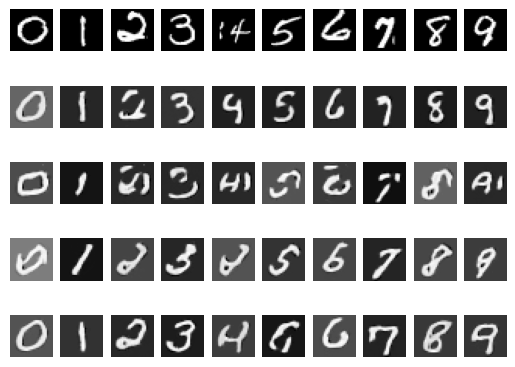

In [13]:
# MNIST 데이터셋 실제 샘플들 및 생성 결과들 저장

original = [ None for _ in range(10) ]

# store original image examples
stop = False
for iter, (image_batch, label_batch) in enumerate(test_dataloader):
    for image, label in zip(image_batch, label_batch):

        label = label.item()

        if original[label] is None:
            original[label] = image.data

        if None not in original:
            stop = True
            break

    if stop: break

noise = torch.randn(1, 1, 28, 28).repeat(10, 1, 1, 1).to(device) # 동일 노이즈
class_label = torch.tensor([ n for n in range(10) ]).to(device)
result1 = generate_images(model, noise, class_label).cpu().detach().numpy() # from noise 1

noise = torch.randn(1, 1, 28, 28).repeat(10, 1, 1, 1).to(device) # 동일 노이즈
class_label = torch.tensor([ n for n in range(10) ]).to(device)
result2 = generate_images(model, noise, class_label).cpu().detach().numpy() # from noise 2

noise = torch.randn(1, 1, 28, 28).repeat(10, 1, 1, 1).to(device) # 동일 노이즈
class_label = torch.tensor([ n for n in range(10) ]).to(device)
result3 = generate_images(model, noise, class_label).cpu().detach().numpy() # from noise 3

noise = torch.randn(1, 1, 28, 28).repeat(10, 1, 1, 1).to(device) # 동일 노이즈
class_label = torch.tensor([ n for n in range(10) ]).to(device)
result4 = generate_images(model, noise, class_label).cpu().detach().numpy() # from noise 4


# MNIST 데이터셋 실제 샘플들 및 생성 결과들 시각화

image_dim=28
fig, ax = plt.subplots(nrows=5, ncols=10)

for i, image in enumerate(original):
    plt.subplot(5, 10, 1*10-(9-i))
    plt.imshow(image.reshape(image_dim, image_dim), cmap="gray")
    plt.axis("off")

for i, image in enumerate(result1):
    plt.subplot(5, 10, 2*10-(9-i))
    plt.imshow(image.reshape(image_dim, image_dim), cmap="gray")
    plt.axis("off")

for i, image in enumerate(result2):
    plt.subplot(5, 10, 3*10-(9-i))
    plt.imshow(image.reshape(image_dim, image_dim), cmap="gray")
    plt.axis("off")

for i, image in enumerate(result3):
    plt.subplot(5, 10, 4*10-(9-i))
    plt.imshow(image.reshape(image_dim, image_dim), cmap="gray")
    plt.axis("off")

for i, image in enumerate(result4):
    plt.subplot(5, 10, 5*10-(9-i))
    plt.imshow(image.reshape(image_dim, image_dim), cmap="gray")
    plt.axis("off")

plt.show()

#### 이미지 생성 단계별 확인

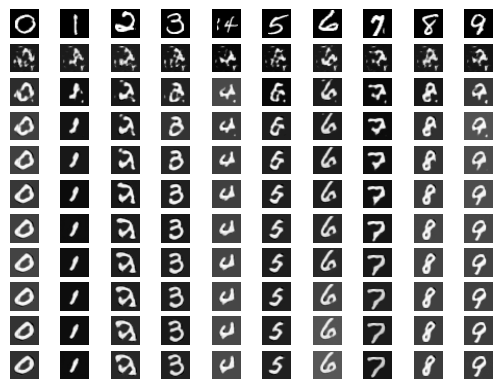

In [14]:
def generate_images2(model, noise, class_label):
    model.eval()
    with torch.no_grad():
        recon_images = list()
        for _ in range(model.num_steps):
            noise = model(noise, class_label)
            recon_images.append(noise.view(class_label.size(0), 1, 28, 28).cpu().detach().numpy())

    return recon_images

noise = torch.randn(1, 1, 28, 28).repeat(10, 1, 1, 1).to(device)
class_label = torch.tensor([ n for n in range(10) ]).to(device)
results = np.array(generate_images2(model, noise, class_label))


# MNIST 데이터셋 실제 샘플들, Diffusion step별 생성 결과들 시각화

image_dim=28
fig, ax = plt.subplots(nrows=11, ncols=10)

for i, image in enumerate(original):
    plt.subplot(11, 10, 1*10-(9-i))
    plt.imshow(image.reshape(image_dim, image_dim), cmap="gray")
    plt.axis("off")

for j, result in enumerate(results):
    for i, image in enumerate(result):
        plt.subplot(11, 10, (j+2)*10-(9-i))
        plt.imshow(image.reshape(image_dim, image_dim), cmap="gray")
        plt.axis("off")

plt.show()